In [5]:
import json
import pandas as pd
import numpy as np
import warnings
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [6]:
def parse_lob(data_str):
    lob_data = {}
    for line in data_str:
        line = line.replace('Exch0', '"Exch0"').replace("'bid'", '"bid"').replace("'ask'", '"ask"')
        data = json.loads(line)

        timestamp = data[0]
        bids = data[2][0][1]
        asks = data[2][1][1]

        highest_bid = max(bids, key=lambda x: x[0])[0] if bids else None
        lowest_ask = min(asks, key=lambda x: x[0])[0] if asks else None

        if timestamp not in lob_data:
            lob_data[timestamp] = {'Bid': highest_bid, 'Ask': lowest_ask}
        else:
            if highest_bid and (lob_data[timestamp]['Bid'] is None or highest_bid > lob_data[timestamp]['Bid']):
                lob_data[timestamp]['Bid'] = highest_bid
            if lowest_ask and (lob_data[timestamp]['Ask'] is None or lowest_ask < lob_data[timestamp]['Ask']):
                lob_data[timestamp]['Ask'] = lowest_ask

    df = pd.DataFrame.from_dict(lob_data, orient='index').reset_index().rename(columns={'index': 'Timestamp'})
    return df


In [7]:
file_path = 'C:/Users/Wilson/Desktop/TB2/Dataminiproject/Dataset2/UoB_Set01_2025-02-12LOBs.txt'
with open(file_path, 'r') as file:
    data_str = file.readlines()
result_df = parse_lob(data_str)

result_df.to_csv('result.csv', index=False)
print(result_df.head(20))


    Timestamp    Bid    Ask
0       0.000    NaN    NaN
1       0.558  208.0    NaN
2       0.713  256.0    NaN
3       0.744  256.0    NaN
4       1.240  341.0    NaN
5       1.581  341.0    NaN
6       1.705  341.0    NaN
7       1.891  341.0  386.0
8       2.077  342.0  386.0
9       2.356  342.0  386.0
10      2.759  342.0  385.0
11      3.162  345.0  385.0
12      3.410  345.0  385.0
13      3.565  345.0  385.0
14      3.782  345.0  385.0
15      4.061  345.0  385.0
16      4.340  344.0  385.0
17      4.402  344.0  385.0
18      4.557  344.0  384.0
19      4.588  344.0  384.0


In [8]:
data = pd.read_csv('result.csv')
data_ffill = data.fillna(method='ffill').dropna()

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_ffill['Bid'].values.reshape(-1,1))


C:\Users\Wilson\AppData\Local\Temp\ipykernel_26600\2369309295.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_ffill = data.fillna(method='ffill').dropna()


In [9]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 1
X, Y = create_dataset(scaled_data, look_back)
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))


In [10]:
# Split data into train and test sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
trainX, testX = X[0:train_size], X[train_size:len(X)]
trainY, testY = Y[0:train_size], Y[train_size:len(Y)]

# Define and compile the LSTM model
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(trainX, trainY, epochs=50, batch_size=128, verbose=2)

Epoch 1/50
2162/2162 - 3s - loss: 0.0514 - 3s/epoch - 1ms/step
Epoch 2/50
2162/2162 - 2s - loss: 7.4163e-04 - 2s/epoch - 886us/step
Epoch 3/50
2162/2162 - 2s - loss: 4.1168e-04 - 2s/epoch - 903us/step
Epoch 4/50
2162/2162 - 2s - loss: 5.8030e-05 - 2s/epoch - 887us/step
Epoch 5/50
2162/2162 - 2s - loss: 3.8581e-05 - 2s/epoch - 915us/step
Epoch 6/50
2162/2162 - 2s - loss: 3.8798e-05 - 2s/epoch - 910us/step
Epoch 7/50
2162/2162 - 2s - loss: 3.8923e-05 - 2s/epoch - 901us/step
Epoch 8/50
2162/2162 - 2s - loss: 3.8816e-05 - 2s/epoch - 897us/step
Epoch 9/50
2162/2162 - 2s - loss: 3.8931e-05 - 2s/epoch - 871us/step
Epoch 10/50
2162/2162 - 2s - loss: 3.8897e-05 - 2s/epoch - 882us/step
Epoch 11/50
2162/2162 - 2s - loss: 3.8878e-05 - 2s/epoch - 873us/step
Epoch 12/50
2162/2162 - 2s - loss: 3.8852e-05 - 2s/epoch - 876us/step
Epoch 13/50
2162/2162 - 2s - loss: 3.8877e-05 - 2s/epoch - 873us/step
Epoch 14/50
2162/2162 - 2s - loss: 3.8822e-05 - 2s/epoch - 873us/step
Epoch 15/50
2162/2162 - 2s - loss: 

In [11]:
# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Invert predictions to be in the original scale of 'Bid' prices
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

# Inverting the scaling for the actual values, to have them in the original scale for comparison
trainY_inv = scaler.inverse_transform([trainY])
testY_inv = scaler.inverse_transform([testY])


2162/2162 [==============================] - 1s 641us/step


In [12]:
from sklearn.metrics import mean_squared_error

trainMSE = mean_squared_error(trainY, model.predict(trainX))
testMSE = mean_squared_error(testY, model.predict(testX))

trainRMSE = np.sqrt(trainMSE)
testRMSE = np.sqrt(testMSE)

print(f'Train RMSE: {trainRMSE}')
print(f'Test RMSE: {testRMSE}')


2162/2162 [==============================] - 1s 647us/step
Train RMSE: 0.006179173305362969
Test RMSE: 0.016639046136133383


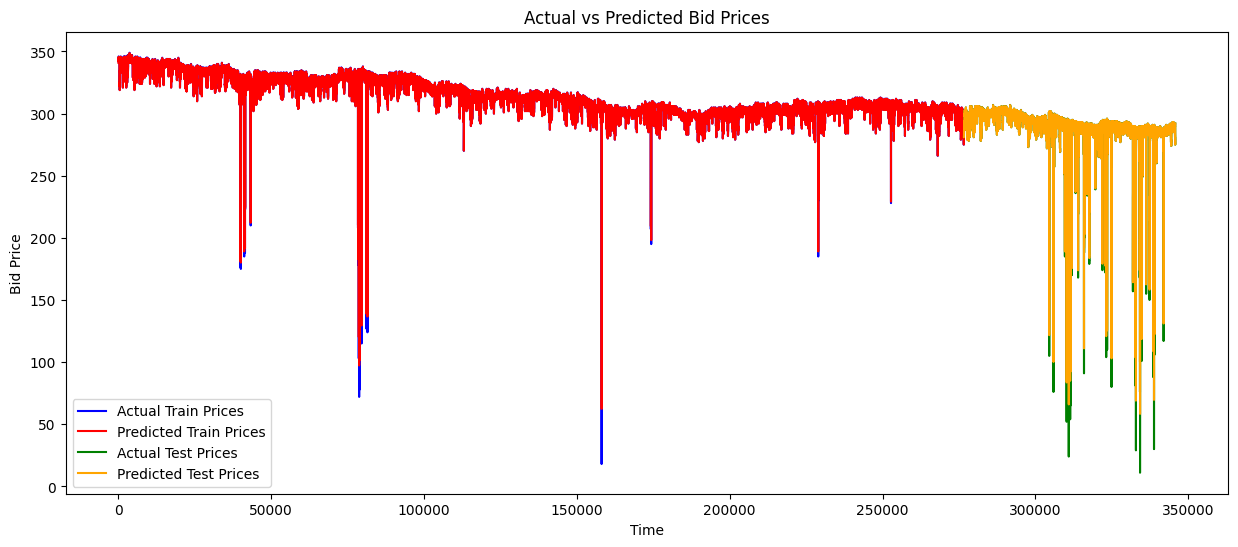

In [13]:
import matplotlib.pyplot as plt


# Generate timestamps for plotting (assuming you have a timestamp array or can generate one)
timestamps = range(len(data_ffill))

# Split the timestamps for training and test data
train_timestamps = timestamps[:len(trainPredict)]
test_timestamps = timestamps[len(trainPredict): (len(trainPredict) + len(testPredict))]

# Actual 'Bid' prices for train and test sets for plotting
actual_train = trainY_inv[0]
actual_test = testY_inv[0]

# Plotting
plt.figure(figsize=(15, 6))

# Plot training data in blue
plt.plot(train_timestamps, actual_train, 'b', label='Actual Train Prices')
plt.plot(train_timestamps, trainPredict[:,0], 'r', label='Predicted Train Prices')

# Plot test data in green
plt.plot(test_timestamps, actual_test, 'g', label='Actual Test Prices')
plt.plot(test_timestamps, testPredict[:,0], 'orange', label='Predicted Test Prices')

plt.xlabel('Time')
plt.ylabel('Bid Price')
plt.title('Actual vs Predicted Bid Prices')
plt.legend()
plt.show()


